In [ ]:
#pip install tensorflow[and-cuda]

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib
import pandas as pd
import random
import keras
from keras import regularizers

In [11]:
# Define constants
image_size = (32, 32)
input_shape = (32, 32, 3)
num_classes = 10
epochs = 100

In [3]:
def CNN():
    return models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')])

In [4]:
def CNN_dropout(value):
    return models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(value),
    layers.Dense(num_classes, activation='softmax')])

In [5]:
def CNN_regulatization(value):
    return models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, kernel_regularizer=regularizers.L2(value), activation='relu'),
    layers.Dense(num_classes, activation='softmax')])

In [14]:
def CNN_regulatization_L1(value):
    return models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, kernel_regularizer=regularizers.L1(value), activation='relu'),
    layers.Dense(num_classes, activation='softmax')])

In [6]:
def residual_block(x, filters, kernel_size=3, strides=1):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # Skip connection
    if strides > 1:
        x = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    out = layers.Add()([x, y])
    out = layers.Activation('relu')(out)
    return out

def ResNet18():
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)
    return model

In [7]:
class TestCase:
    def __init__(self, name, train_datagen, test_datagen, model):
        self.name = name
        self.train_datagen = train_datagen
        self.test_datagen = test_datagen
        self.model = model

    def Test(self, batch_size = 64):
        random.seed(1)
        keras.utils.set_random_seed(1)
        
        train_generator = self.train_datagen.flow_from_directory(
            'data/train',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
            )   

        test_generator = self.test_datagen.flow_from_directory(
            'data/test',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )
        
        self.model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=test_generator,
        )
        
        hist_df = pd.DataFrame(self.history.history) 
        hist_df.to_csv(f"{self.name}.csv")
        
    

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

test1 = TestCase("CNN_na_czysto", train_datagen, test_datagen, CNN())
test1.Test()

test2 = TestCase("CNN_dropout_0_3", train_datagen, test_datagen, CNN_dropout(0.3))
test2.Test()

test3 = TestCase("CNN_regulatization_0.1", train_datagen, test_datagen, CNN_regulatization(0.1))
test3.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
1407/1407 [==============================] - 46s 33ms/step - loss: 1.5496 - accuracy: 0.4275 - val_loss: 1.4390 - val_accuracy: 0.4852
Epoch 2/100
1407/1407 [==============================] - 46s 32ms/step - loss: 1.2330 - accuracy: 0.5535 - val_loss: 1.2125 - val_accuracy: 0.5635
Epoch 3/100
1407/1407 [==============================] - 45s 32ms/step - loss: 1.0899 - accuracy: 0.6082 - val_loss: 1.1029 - val_accuracy: 0.6054
Epoch 4/100
1407/1407 [==============================] - 47s 33ms/step - loss: 0.9791 - accuracy: 0.6491 - val_loss: 1.0900 - val_accuracy: 0.6096
Epoch 5/100
1407/1407 [==============================] - 47s 33ms/step - loss: 0.8884 - accuracy: 0.6816 - val_loss: 1.0764 - val_accuracy: 0.6226
Epoch 6/100
1407/1407 [==============================] - 46s 33ms/step - loss: 0.8035 - accuracy: 0.7105 - val_loss: 1.1223 - val_accuracy: 0.6147
Epoch 7/100
1407/1407 [=======

In [13]:
test4 = TestCase("CNN_dropout_0_5", train_datagen, test_datagen, CNN_dropout(0.5))
test4.Test()

test5 = TestCase("CNN_dropout_0_1", train_datagen, test_datagen, CNN_dropout(0.1))
test5.Test()



Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.6120 - accuracy: 0.3998 - val_loss: 1.4353 - val_accuracy: 0.4790
Epoch 2/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.3061 - accuracy: 0.5257 - val_loss: 1.2348 - val_accuracy: 0.5516
Epoch 3/100
1407/1407 [==============================] - 46s 33ms/step - loss: 1.1696 - accuracy: 0.5791 - val_loss: 1.1382 - val_accuracy: 0.5901
Epoch 4/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.0790 - accuracy: 0.6131 - val_loss: 1.1159 - val_accuracy: 0.6044
Epoch 5/100
1407/1407 [==============================] - 46s 33ms/step - loss: 1.0064 - accuracy: 0.6395 - val_loss: 1.0863 - val_accuracy: 0.6129
Epoch 6/100
1407/1407 [==============================] - 46s 33ms/step - loss: 0.9474 - accuracy: 0.6583 - val_loss: 1.0754 - val_accuracy: 0.6175
Epoch 7/100
1407/1407 [=======

KeyboardInterrupt: 

In [15]:
test6 = TestCase("CNN_regulatization_0.2", train_datagen, test_datagen, CNN_regulatization(0.2))
test6.Test()

test7 = TestCase("CNN_regulatization_0.3", train_datagen, test_datagen, CNN_regulatization(0.3))
test7.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
1407/1407 [==============================] - 48s 34ms/step - loss: 3.5506 - accuracy: 0.3260 - val_loss: 1.7553 - val_accuracy: 0.3823
Epoch 2/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.6464 - accuracy: 0.4127 - val_loss: 1.6010 - val_accuracy: 0.4491
Epoch 3/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.5475 - accuracy: 0.4576 - val_loss: 1.5337 - val_accuracy: 0.4686
Epoch 4/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.4702 - accuracy: 0.4911 - val_loss: 1.4528 - val_accuracy: 0.5017
Epoch 5/100
1407/1407 [==============================] - 47s 33ms/step - loss: 1.4032 - accuracy: 0.5174 - val_loss: 1.4440 - val_accuracy: 0.5104
Epoch 6/100
1407/1407 [==============================] - 46s 33ms/step - loss: 1.3539 - accuracy: 0.5365 - val_loss: 1.3486 - val_accuracy: 0.5401
Epoch 7/100
1407/1407 [=======

In [16]:
test8 = TestCase("CNN_na_czysto_batch_32", train_datagen, test_datagen, CNN())
test8.Test(batch_size=32)

test9 = TestCase("CNN_na_czysto_batch_16", train_datagen, test_datagen, CNN())
test9.Test(batch_size=16)

test10 = TestCase("CNN_na_czysto_batch_8", train_datagen, test_datagen, CNN())
test10.Test(batch_size=8)

test11 = TestCase("CNN_na_czysto_batch_128", train_datagen, test_datagen, CNN())
test11.Test(batch_size=128)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
2813/2813 [==============================] - 51s 18ms/step - loss: 1.5391 - accuracy: 0.4314 - val_loss: 1.3294 - val_accuracy: 0.5190
Epoch 2/100
2813/2813 [==============================] - 50s 18ms/step - loss: 1.2360 - accuracy: 0.5511 - val_loss: 1.2711 - val_accuracy: 0.5450
Epoch 3/100
2813/2813 [==============================] - 49s 18ms/step - loss: 1.1042 - accuracy: 0.6000 - val_loss: 1.1468 - val_accuracy: 0.5860
Epoch 4/100
2813/2813 [==============================] - 49s 17ms/step - loss: 1.0077 - accuracy: 0.6373 - val_loss: 1.1277 - val_accuracy: 0.6010
Epoch 5/100
2813/2813 [==============================] - 50s 18ms/step - loss: 0.9258 - accuracy: 0.6669 - val_loss: 1.1219 - val_accuracy: 0.6096
Epoch 6/100
2813/2813 [==============================] - 49s 17ms/step - loss: 0.8467 - accuracy: 0.6956 - val_loss: 1.1020 - val_accuracy: 0.6173
Epoch 7/100
2813/2813 [=======

In [17]:
test12 = TestCase("CNN_regulatization_L1_0_1", train_datagen, test_datagen, CNN_regulatization_L1(0.1))
test12.Test()

test13 = TestCase("CNN_regulatization_L1_0_2", train_datagen, test_datagen, CNN_regulatization_L1(0.2))
test13.Test()

test14 = TestCase("CNN_regulatization_L1_0_3", train_datagen, test_datagen, CNN_regulatization_L1(0.3))
test14.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
1407/1407 [==============================] - 48s 34ms/step - loss: 34.3040 - accuracy: 0.2188 - val_loss: 8.1647 - val_accuracy: 0.2568
Epoch 2/100
1407/1407 [==============================] - 49s 35ms/step - loss: 7.9884 - accuracy: 0.3044 - val_loss: 7.9400 - val_accuracy: 0.3297
Epoch 3/100
1407/1407 [==============================] - 50s 36ms/step - loss: 7.8660 - accuracy: 0.3336 - val_loss: 7.8445 - val_accuracy: 0.3416
Epoch 4/100
1407/1407 [==============================] - 50s 36ms/step - loss: 7.7882 - accuracy: 0.3620 - val_loss: 7.7476 - val_accuracy: 0.3864
Epoch 5/100
1407/1407 [==============================] - 50s 36ms/step - loss: 7.7053 - accuracy: 0.3916 - val_loss: 7.6692 - val_accuracy: 0.4030
Epoch 6/100
1407/1407 [==============================] - 51s 36ms/step - loss: 7.6562 - accuracy: 0.4100 - val_loss: 7.6843 - val_accuracy: 0.4121
Epoch 7/100
1407/1407 [======

In [19]:
epochs = 40
test15 = TestCase("ResNet18", train_datagen, test_datagen, ResNet18())
test15.Test()

test16 = TestCase("ResNet18_batch_32", train_datagen, test_datagen, ResNet18())
test16.Test(batch_size=32)

test17 = TestCase("ResNet18_batch_16", train_datagen, test_datagen, ResNet18())
test17.Test(batch_size=16)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/40
1407/1407 [==============================] - 111s 78ms/step - loss: 1.4235 - accuracy: 0.4803 - val_loss: 1.2787 - val_accuracy: 0.5360
Epoch 2/40
1407/1407 [==============================] - 107s 76ms/step - loss: 1.0960 - accuracy: 0.6047 - val_loss: 1.5699 - val_accuracy: 0.4746
Epoch 3/40
1407/1407 [==============================] - 107s 76ms/step - loss: 0.9394 - accuracy: 0.6629 - val_loss: 1.2541 - val_accuracy: 0.5611
Epoch 4/40
1407/1407 [==============================] - 106s 76ms/step - loss: 0.8097 - accuracy: 0.7114 - val_loss: 1.2970 - val_accuracy: 0.5647
Epoch 5/40
1407/1407 [==============================] - 107s 76ms/step - loss: 0.6822 - accuracy: 0.7548 - val_loss: 1.0055 - val_accuracy: 0.6516
Epoch 6/40
1407/1407 [==============================] - 107s 76ms/step - loss: 0.5509 - accuracy: 0.8031 - val_loss: 1.1402 - val_accuracy: 0.6518
Epoch 7/40
1407/1407 [========

KeyboardInterrupt: 

In [21]:
test18 = TestCase("ResNet18_batch_128", train_datagen, test_datagen, ResNet18())
test18.Test(batch_size=128)

Found 90000 images belonging to 10 classes.


KeyboardInterrupt: 

In [20]:
epochs = 250
test19 = TestCase("ResNet18_augmentation_all", ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9,1.1],
    fill_mode='nearest'
), test_datagen, ResNet18())
test19.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
1407/1407 [==============================] - 115s 80ms/step - loss: 1.6902 - accuracy: 0.3702 - val_loss: 1.7220 - val_accuracy: 0.3853
Epoch 2/100
1407/1407 [==============================] - 113s 80ms/step - loss: 1.4250 - accuracy: 0.4744 - val_loss: 1.9916 - val_accuracy: 0.3660
Epoch 3/100
1407/1407 [==============================] - 114s 81ms/step - loss: 1.2973 - accuracy: 0.5255 - val_loss: 1.4418 - val_accuracy: 0.5062
Epoch 4/100
1407/1407 [==============================] - 113s 80ms/step - loss: 1.2188 - accuracy: 0.5563 - val_loss: 1.2765 - val_accuracy: 0.5439
Epoch 5/100
1407/1407 [==============================] - 110s 78ms/step - loss: 1.1531 - accuracy: 0.5836 - val_loss: 1.2344 - val_accuracy: 0.5600
Epoch 6/100
1407/1407 [==============================] - 113s 80ms/step - loss: 1.0988 - accuracy: 0.6028 - val_loss: 1.5157 - val_accuracy: 0.4946
Epoch 7/100
1407/1407 [=

In [37]:
epochs = 100
test26 = TestCase("CNN_augmentation_all_2", ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=25,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.6],
    fill_mode='nearest'
), test_datagen, CNN_dropout(0.3))
test26.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
1407/1407 [==============================] - 128s 90ms/step - loss: 1.9561 - accuracy: 0.2617 - val_loss: 1.7890 - val_accuracy: 0.3327
Epoch 2/100
1407/1407 [==============================] - 127s 90ms/step - loss: 1.8040 - accuracy: 0.3286 - val_loss: 1.6594 - val_accuracy: 0.3798
Epoch 3/100
1407/1407 [==============================] - 127s 90ms/step - loss: 1.7351 - accuracy: 0.3563 - val_loss: 1.5493 - val_accuracy: 0.4216
Epoch 4/100
1407/1407 [==============================] - 130s 92ms/step - loss: 1.6934 - accuracy: 0.3761 - val_loss: 1.5385 - val_accuracy: 0.4304
Epoch 5/100
1407/1407 [==============================] - 127s 90ms/step - loss: 1.6625 - accuracy: 0.3879 - val_loss: 1.4853 - val_accuracy: 0.4489
Epoch 6/100
1407/1407 [==============================] - 129s 92ms/step - loss: 1.6428 - accuracy: 0.3952 - val_loss: 1.4869 - val_accuracy: 0.4497
Epoch 7/100
1407/1407 [=

KeyboardInterrupt: 

In [30]:
epochs = 250
test20 = TestCase("ResNet18_augmentation_all_2", ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=45,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.6],
    fill_mode='nearest'
), test_datagen, ResNet18())
test20.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/250
1407/1407 [==============================] - 116s 81ms/step - loss: 2.0166 - accuracy: 0.2483 - val_loss: 1.9794 - val_accuracy: 0.2539
Epoch 2/250
1407/1407 [==============================] - 119s 85ms/step - loss: 1.8523 - accuracy: 0.3131 - val_loss: 2.3291 - val_accuracy: 0.2649
Epoch 3/250
1407/1407 [==============================] - 115s 82ms/step - loss: 1.7657 - accuracy: 0.3483 - val_loss: 1.6444 - val_accuracy: 0.3963
Epoch 4/250
1407/1407 [==============================] - 114s 81ms/step - loss: 1.7064 - accuracy: 0.3726 - val_loss: 1.6587 - val_accuracy: 0.4006
Epoch 5/250
1407/1407 [==============================] - 114s 81ms/step - loss: 1.6585 - accuracy: 0.3913 - val_loss: 1.5583 - val_accuracy: 0.4261
Epoch 6/250
1407/1407 [==============================] - 115s 82ms/step - loss: 1.6200 - accuracy: 0.4058 - val_loss: 1.5635 - val_accuracy: 0.4334
Epoch 7/250
1407/1407 [=

In [23]:
epochs = 80
test21 = TestCase("CNN_augmentation_shifts", ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest'
), test_datagen, CNN_dropout(0.3))
test21.Test(batch_size=128)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 91s 63ms/step - loss: 1.8021 - accuracy: 0.3221 - val_loss: 1.6636 - val_accuracy: 0.3931
Epoch 2/80
1407/1407 [==============================] - 89s 63ms/step - loss: 1.5648 - accuracy: 0.4237 - val_loss: 1.3879 - val_accuracy: 0.4903
Epoch 3/80
1407/1407 [==============================] - 88s 63ms/step - loss: 1.4609 - accuracy: 0.4657 - val_loss: 1.3993 - val_accuracy: 0.4867
Epoch 4/80
1407/1407 [==============================] - 88s 63ms/step - loss: 1.3963 - accuracy: 0.4931 - val_loss: 1.2444 - val_accuracy: 0.5465
Epoch 5/80
1407/1407 [==============================] - 88s 63ms/step - loss: 1.3404 - accuracy: 0.5148 - val_loss: 1.2026 - val_accuracy: 0.5638
Epoch 6/80
1407/1407 [==============================] - 87s 62ms/step - loss: 1.2989 - accuracy: 0.5297 - val_loss: 1.2109 - val_accuracy: 0.5651
Epoch 7/80
1407/1407 [==============

In [24]:
epochs = 80
test22 = TestCase("CNN_augmentation_rotation", ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    fill_mode='nearest'
), test_datagen, CNN_dropout(0.3))
test22.Test(batch_size=128)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 85s 60ms/step - loss: 1.6391 - accuracy: 0.3942 - val_loss: 1.5634 - val_accuracy: 0.4492
Epoch 2/80
1407/1407 [==============================] - 85s 60ms/step - loss: 1.3876 - accuracy: 0.4941 - val_loss: 1.3242 - val_accuracy: 0.5266
Epoch 3/80
1407/1407 [==============================] - 85s 60ms/step - loss: 1.2761 - accuracy: 0.5354 - val_loss: 1.3188 - val_accuracy: 0.5400
Epoch 4/80
1407/1407 [==============================] - 85s 61ms/step - loss: 1.2027 - accuracy: 0.5639 - val_loss: 1.3902 - val_accuracy: 0.5252
Epoch 5/80
1407/1407 [==============================] - 86s 61ms/step - loss: 1.1466 - accuracy: 0.5878 - val_loss: 1.1436 - val_accuracy: 0.5937
Epoch 6/80
1407/1407 [==============================] - 85s 61ms/step - loss: 1.0939 - accuracy: 0.6070 - val_loss: 1.1196 - val_accuracy: 0.5993
Epoch 7/80
1407/1407 [==============

In [25]:
epochs = 80
test23 = TestCase("CNN_augmentation_shear", ImageDataGenerator(
    rescale=1./255,
    shear_range=45,
    fill_mode='nearest'
), test_datagen, CNN_dropout(0.3))
test23.Test(batch_size=128)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 85s 61ms/step - loss: 1.5475 - accuracy: 0.4292 - val_loss: 1.4097 - val_accuracy: 0.4959
Epoch 2/80
1407/1407 [==============================] - 86s 61ms/step - loss: 1.2281 - accuracy: 0.5558 - val_loss: 1.1771 - val_accuracy: 0.5738
Epoch 3/80
1407/1407 [==============================] - 87s 62ms/step - loss: 1.0871 - accuracy: 0.6081 - val_loss: 1.1669 - val_accuracy: 0.5890
Epoch 4/80
1407/1407 [==============================] - 86s 61ms/step - loss: 0.9739 - accuracy: 0.6516 - val_loss: 1.0873 - val_accuracy: 0.6138
Epoch 5/80
1407/1407 [==============================] - 87s 62ms/step - loss: 0.8878 - accuracy: 0.6822 - val_loss: 1.0627 - val_accuracy: 0.6257
Epoch 6/80
1407/1407 [==============================] - 87s 62ms/step - loss: 0.7981 - accuracy: 0.7143 - val_loss: 1.0871 - val_accuracy: 0.6249
Epoch 7/80
1407/1407 [==============

In [26]:
epochs = 80
test24 = TestCase("CNN_augmentation_zoom", ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5,
    fill_mode='nearest'
), test_datagen, CNN_dropout(0.3))
test24.Test(batch_size=128)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 87s 61ms/step - loss: 1.6302 - accuracy: 0.4021 - val_loss: 1.5795 - val_accuracy: 0.4422
Epoch 2/80
1407/1407 [==============================] - 88s 63ms/step - loss: 1.3551 - accuracy: 0.5114 - val_loss: 1.2395 - val_accuracy: 0.5520
Epoch 3/80
1407/1407 [==============================] - 88s 62ms/step - loss: 1.2373 - accuracy: 0.5552 - val_loss: 1.2794 - val_accuracy: 0.5506
Epoch 4/80
1407/1407 [==============================] - 88s 62ms/step - loss: 1.1545 - accuracy: 0.5873 - val_loss: 1.1430 - val_accuracy: 0.5915
Epoch 5/80
1407/1407 [==============================] - 89s 63ms/step - loss: 1.0890 - accuracy: 0.6103 - val_loss: 1.0854 - val_accuracy: 0.6134
Epoch 6/80
1407/1407 [==============================] - 88s 62ms/step - loss: 1.0379 - accuracy: 0.6292 - val_loss: 1.0837 - val_accuracy: 0.6156
Epoch 7/80
1407/1407 [==============

In [27]:
epochs = 80
test25 = TestCase("CNN_augmentation_channel_shift", ImageDataGenerator(
    rescale=1./255,
    channel_shift_range=80,
    fill_mode='nearest'
), test_datagen, CNN_dropout(0.3))
test25.Test(batch_size=128)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 65s 46ms/step - loss: 1.5473 - accuracy: 0.4300 - val_loss: 1.4263 - val_accuracy: 0.4911
Epoch 2/80
1407/1407 [==============================] - 65s 46ms/step - loss: 1.2336 - accuracy: 0.5532 - val_loss: 1.1785 - val_accuracy: 0.5701
Epoch 3/80
1407/1407 [==============================] - 65s 46ms/step - loss: 1.0902 - accuracy: 0.6071 - val_loss: 1.1339 - val_accuracy: 0.5957
Epoch 4/80
1407/1407 [==============================] - 65s 46ms/step - loss: 0.9813 - accuracy: 0.6489 - val_loss: 1.1251 - val_accuracy: 0.6027
Epoch 5/80
1407/1407 [==============================] - 65s 46ms/step - loss: 0.8961 - accuracy: 0.6770 - val_loss: 1.0775 - val_accuracy: 0.6209
Epoch 6/80
1407/1407 [==============================] - 65s 46ms/step - loss: 0.8065 - accuracy: 0.7099 - val_loss: 1.0532 - val_accuracy: 0.6309
Epoch 7/80
1407/1407 [==============

In [31]:
epochs = 80
test26 = TestCase("ResNet18_augmentation_shifts", ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest'
), test_datagen, ResNet18())
test26.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 118s 83ms/step - loss: 1.6918 - accuracy: 0.3709 - val_loss: 1.8621 - val_accuracy: 0.3928
Epoch 2/80
1407/1407 [==============================] - 111s 79ms/step - loss: 1.3855 - accuracy: 0.4948 - val_loss: 1.6614 - val_accuracy: 0.4595
Epoch 3/80
1407/1407 [==============================] - 111s 79ms/step - loss: 1.2384 - accuracy: 0.5545 - val_loss: 1.6289 - val_accuracy: 0.4718
Epoch 4/80
1407/1407 [==============================] - 112s 80ms/step - loss: 1.1397 - accuracy: 0.5950 - val_loss: 1.7651 - val_accuracy: 0.4383
Epoch 5/80
1407/1407 [==============================] - 112s 79ms/step - loss: 1.0542 - accuracy: 0.6246 - val_loss: 1.0877 - val_accuracy: 0.6117
Epoch 6/80
1407/1407 [==============================] - 112s 79ms/step - loss: 0.9967 - accuracy: 0.6482 - val_loss: 1.0425 - val_accuracy: 0.6247
Epoch 7/80
1407/1407 [========

In [32]:
epochs = 100
test27 = TestCase("ResNet18_augmentation_rotation", ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    fill_mode='nearest'
), test_datagen, ResNet18())
test27.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/100
1407/1407 [==============================] - 118s 82ms/step - loss: 1.6055 - accuracy: 0.4092 - val_loss: 1.4380 - val_accuracy: 0.4789
Epoch 2/100
1407/1407 [==============================] - 115s 82ms/step - loss: 1.3483 - accuracy: 0.5082 - val_loss: 1.5109 - val_accuracy: 0.4576
Epoch 3/100
1407/1407 [==============================] - 114s 81ms/step - loss: 1.2252 - accuracy: 0.5558 - val_loss: 1.2803 - val_accuracy: 0.5355
Epoch 4/100
1407/1407 [==============================] - 115s 82ms/step - loss: 1.1352 - accuracy: 0.5920 - val_loss: 1.3475 - val_accuracy: 0.5310
Epoch 5/100
1407/1407 [==============================] - 115s 82ms/step - loss: 1.0591 - accuracy: 0.6214 - val_loss: 1.2150 - val_accuracy: 0.5810
Epoch 6/100
1407/1407 [==============================] - 114s 81ms/step - loss: 0.9938 - accuracy: 0.6456 - val_loss: 1.0166 - val_accuracy: 0.6399
Epoch 7/100
1407/1407 [=

In [33]:
epochs = 80
test28 = TestCase("ResNet18_augmentation_shear", ImageDataGenerator(
    rescale=1./255,
    shear_range=45,
    fill_mode='nearest'
), test_datagen, ResNet18())
test28.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 113s 79ms/step - loss: 1.5642 - accuracy: 0.4251 - val_loss: 1.5375 - val_accuracy: 0.4346
Epoch 2/80
1407/1407 [==============================] - 113s 80ms/step - loss: 1.2760 - accuracy: 0.5367 - val_loss: 1.7165 - val_accuracy: 0.4526
Epoch 3/80
1407/1407 [==============================] - 117s 83ms/step - loss: 1.1524 - accuracy: 0.5823 - val_loss: 1.1968 - val_accuracy: 0.5640
Epoch 4/80
1407/1407 [==============================] - 111s 79ms/step - loss: 1.0689 - accuracy: 0.6147 - val_loss: 1.1058 - val_accuracy: 0.6049
Epoch 5/80
1407/1407 [==============================] - 111s 79ms/step - loss: 0.9911 - accuracy: 0.6465 - val_loss: 1.0951 - val_accuracy: 0.6162
Epoch 6/80
1407/1407 [==============================] - 111s 79ms/step - loss: 0.9233 - accuracy: 0.6683 - val_loss: 1.0475 - val_accuracy: 0.6299
Epoch 7/80
1407/1407 [========

In [34]:
epochs = 80
test29 = TestCase("ResNet18_augmentation_zoom", ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5,
    fill_mode='nearest'
), test_datagen, ResNet18())
test29.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 114s 80ms/step - loss: 1.6367 - accuracy: 0.3993 - val_loss: 1.6164 - val_accuracy: 0.4469
Epoch 2/80
1407/1407 [==============================] - 111s 79ms/step - loss: 1.3456 - accuracy: 0.5110 - val_loss: 1.7078 - val_accuracy: 0.4443
Epoch 3/80
1407/1407 [==============================] - 111s 79ms/step - loss: 1.2115 - accuracy: 0.5655 - val_loss: 1.5196 - val_accuracy: 0.5061
Epoch 4/80
1407/1407 [==============================] - 112s 80ms/step - loss: 1.1096 - accuracy: 0.6034 - val_loss: 1.5370 - val_accuracy: 0.4931
Epoch 5/80
1407/1407 [==============================] - 111s 79ms/step - loss: 1.0366 - accuracy: 0.6296 - val_loss: 1.0130 - val_accuracy: 0.6413
Epoch 6/80
1407/1407 [==============================] - 112s 80ms/step - loss: 0.9708 - accuracy: 0.6540 - val_loss: 0.9834 - val_accuracy: 0.6590
Epoch 7/80
1407/1407 [========

In [35]:
epochs = 80
test25 = TestCase("ResNet18_augmentation_channel_shift", ImageDataGenerator(
    rescale=1./255,
    channel_shift_range=80,
    fill_mode='nearest'
), test_datagen, ResNet18())
test25.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 117s 82ms/step - loss: 1.5265 - accuracy: 0.4403 - val_loss: 1.4457 - val_accuracy: 0.4748
Epoch 2/80
1407/1407 [==============================] - 114s 81ms/step - loss: 1.1861 - accuracy: 0.5718 - val_loss: 1.3277 - val_accuracy: 0.5372
Epoch 3/80
1407/1407 [==============================] - 114s 81ms/step - loss: 1.0203 - accuracy: 0.6335 - val_loss: 1.0482 - val_accuracy: 0.6333
Epoch 4/80
1407/1407 [==============================] - 115s 81ms/step - loss: 0.8924 - accuracy: 0.6831 - val_loss: 1.0410 - val_accuracy: 0.6386
Epoch 5/80
1407/1407 [==============================] - 115s 82ms/step - loss: 0.7772 - accuracy: 0.7256 - val_loss: 0.9411 - val_accuracy: 0.6679
Epoch 6/80
1407/1407 [==============================] - 118s 84ms/step - loss: 0.6611 - accuracy: 0.7638 - val_loss: 1.0384 - val_accuracy: 0.6519
Epoch 7/80
1407/1407 [========

In [36]:
epochs = 80
test15 = TestCase("ResNet18_v2", train_datagen, test_datagen, ResNet18())
test15.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/80
1407/1407 [==============================] - 119s 83ms/step - loss: 1.4223 - accuracy: 0.4795 - val_loss: 1.2243 - val_accuracy: 0.5543
Epoch 2/80
1407/1407 [==============================] - 116s 82ms/step - loss: 1.0982 - accuracy: 0.6037 - val_loss: 1.3837 - val_accuracy: 0.5249
Epoch 3/80
1407/1407 [==============================] - 115s 82ms/step - loss: 0.9435 - accuracy: 0.6615 - val_loss: 1.2178 - val_accuracy: 0.5754
Epoch 4/80
1407/1407 [==============================] - 115s 82ms/step - loss: 0.8174 - accuracy: 0.7081 - val_loss: 1.1105 - val_accuracy: 0.6175
Epoch 5/80
1407/1407 [==============================] - 115s 82ms/step - loss: 0.6933 - accuracy: 0.7523 - val_loss: 1.1044 - val_accuracy: 0.6316
Epoch 6/80
1407/1407 [==============================] - 116s 82ms/step - loss: 0.5624 - accuracy: 0.7993 - val_loss: 1.0461 - val_accuracy: 0.6655
Epoch 7/80
1407/1407 [========

In [ ]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9,1.1],
    fill_mode='nearest'
)


1/1 [==============================] - 0s 17ms/step


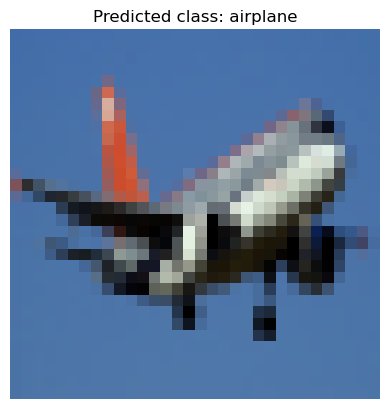

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Get a random image from the test set
#random_class = 'plane'
#random_image_path = os.path.join('data/test', random_class)
random_image_files = os.listdir('data/test')
random_image_file = np.random.choice(random_image_files)
random_image = image.load_img(os.path.join('data/test', random_image_file), target_size=image_size)
random_image_array = image.img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0) / 255.0  # Rescale to [0,1]

# Predict the class of the random image
predictions = model.predict(random_image_array)
predicted_class_index = np.argmax(predictions)
predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]

# Display the image and its predicted class
plt.imshow(random_image)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()


## inne

In [20]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import pathlib
import cv2
import os
from os import listdir
import glob
from PIL import Image

cinic_directory_train = './data/train'
cinic_directory_test = './data/test'

class_name = []
file_name='output_fromKeras.csv'
optimiser='adamax' # les best : Adam, nadam et adamax
nb_epochs=50
batch_size_choice=16
image_size=(32, 32)
loss_func='sparse_categorical_crossentropy'

In [21]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_choice
)

Found 90000 files belonging to 10 classes.
Using 72000 files for training.


In [22]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_choice
)

Found 90000 files belonging to 10 classes.
Using 18000 files for validation.


In [23]:
class_names= train_ds.class_names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [24]:
def make_model_keras2(input_shape, num_classes):
    # Build the model using the functional API
    # input layer
    i = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.2)(x)

    # Hidden layer
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    # last hidden layer i.e.. output layer
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(i, x)

In [25]:
model = make_model_keras2(input_shape=(32,32, 3), num_classes=10)

model.compile(
    optimizer=optimiser,  #Fonction d'optimisation    
    loss=loss_func, #voir la doc de tensorflow "losses"
    metrics=['accuracy']
)

In [26]:
resultFile = []

total = 0
list = os.scandir(cinic_directory_test)
for testPicture in list:
    image_to_predict = cv2.imread(testPicture.path, cv2.IMREAD_COLOR)
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict, (32, 32)), axis=0)
    
    #prediction
    res = np.argmax(model.predict(img_to_predict), axis=-1)
    resultFile.append(testPicture.name + ',' + class_names[res[0]])
    
    total += 1
    print("Total images : " + str(total), end='\r')
    # print(resultFile)
    
    
    
f = open(file_name, 'w')
f.write('filename,label')
f.write('\n')
for resultLine in resultFile:
    f.write(resultLine)
    f.write('\n')
f.close()

1/1 [==============================] - 0s 65ms/step
